# DivNoising - Prediction
This notebook contains an example on how to use a previously trained DivNoising VAE to denoise images.
If you haven't done so please first run 'Convallaria-CreateNoiseModel.ipynb' and 'Convallaria-Training.ipynb', which will download the data, create a noise model and train the VAE.  

In [1]:
# We import all our dependencies.
import urllib
import os
import zipfile
import numpy as np
from tqdm import tqdm
from tifffile import imread
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../../')

from divnoising import dataLoader
from divnoising import utils
from divnoising import training_multi
from nets import model_multi
import torch
from divnoising.utils import loadImages

from tqdm import tqdm

# Load data to predict on

/home/prakash/anaconda3/envs/FastAI/lib/python3.6/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/home/prakash/anaconda3/envs/FastAI/lib/python3.6/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


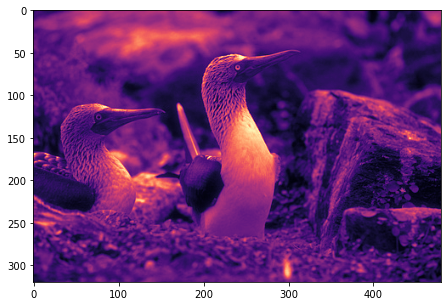

In [2]:
signal_ = np.load('data/BSD68_reproducibility_data/test/bsd68_groundtruth.npy', allow_pickle=True)
# path="../../../../../fileserver_MultiDenSeg/experiments/Rebuttal/Set14/"
signal = []

for f in range(signal_.shape[0]):
    a = signal_[f][:-1,:-1]
    signal.append(a)
signal = np.array(signal)

observation = []
gaussian_noise_std = 25

for img in range(signal.shape[0]):
    observation.append(signal[img]+np.random.randn(signal[img].shape[0], signal[img].shape[1])*gaussian_noise_std)

observation = np.array(observation)

img_width, img_height = signal[0].shape[0], signal[0].shape[1]

plt.figure(figsize=(15, 5))
plt.imshow(signal[0],cmap='magma')

# Load our model

In [13]:
vae = torch.load("./bsd68-10filters-blurlast_vae.net")

# Here we predict some qulitative diverse solutions

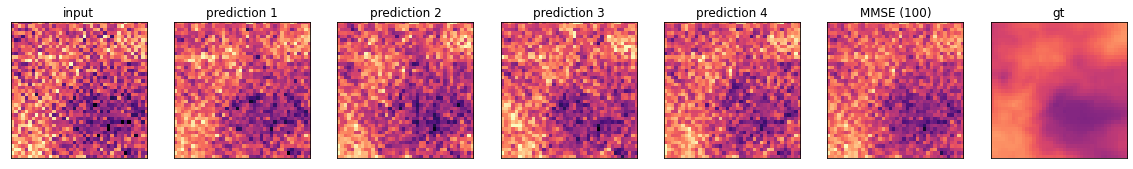

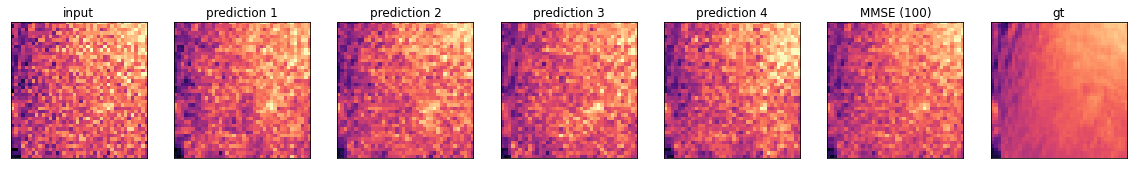

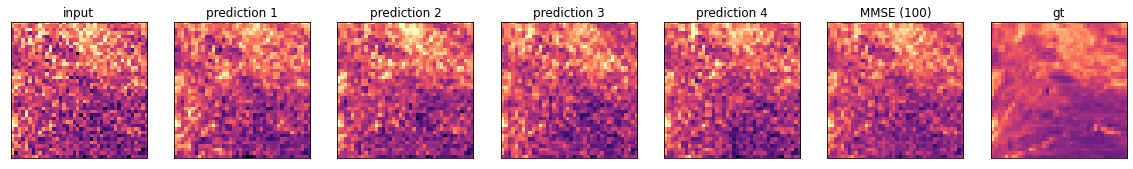

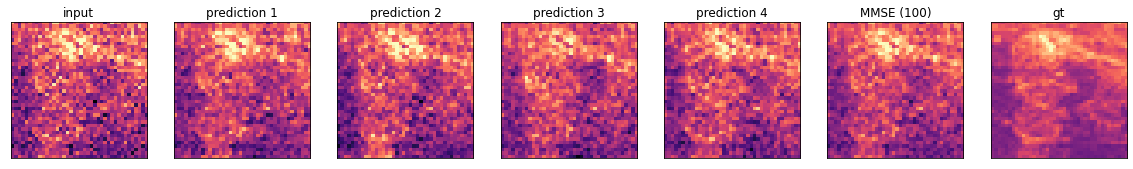

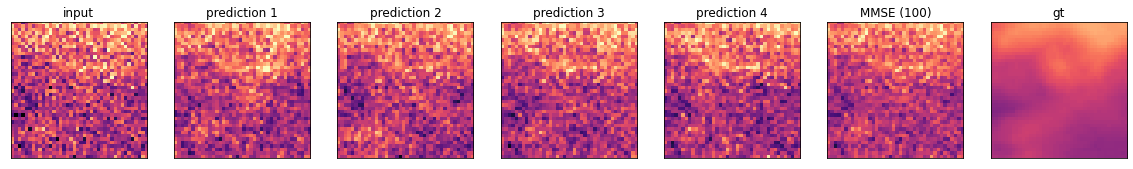

In [14]:
for j in range(5):  
    
    # we select a random crop
    size=40
    minx=np.random.randint(0,signal[0].shape[0]-size)
    miny=np.random.randint(0,signal[0].shape[1]-size)
    gt=signal[0][minx:minx+size,miny:miny+size]
    img=observation[0][minx:minx+size,miny:miny+size]
    imgT=torch.Tensor(img)
    
    # determine the min and max value for display
    vmin=np.percentile(img,0)
    vmax=np.percentile(img,99)
    
    # generate samples and MMSE estimate
    imgMMSE, samps=utils.predictMMSE(vae, imgT, 100, returnSamples=True, tq=False)
    
    plt.figure(figsize=(20, 6.75))
    
    # We display the noisy input image
    ax=plt.subplot(1,7,1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(img,vmin=vmin, vmax=vmax,cmap='magma')
    plt.title('input')
    
    # We display the ground truth
    ax=plt.subplot(1,7,7)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(gt,vmin=vmin, vmax=vmax,cmap='magma')
    plt.title('gt')

    # We display the average of 100 predicted samples
    ax=plt.subplot(1,7,6)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(imgMMSE,vmin=vmin, vmax=vmax,cmap='magma')
    plt.title('MMSE (100)')
    
    #We also display the first 4 samples
    for i in range(4):     
        ax=plt.subplot(1,7,i+2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(samps[i],vmin=vmin, vmax=vmax,cmap='magma')
        plt.title('prediction '+str(i+1))

    plt.show()

# Compute PSNR and the dataset

In [5]:
def PSNR(gt, img):
    '''
    Compute PSNR.
    Parameters
    ----------
    gt: array
        Ground truth image.
    img: array
        Predicted image.''
    '''
    mse = np.mean(np.square(gt - img))
    return 20 * np.log10(255) - 10 * np.log10(mse)

In [6]:
vae = torch.load("./bsd68-10filters-blurlast_vae.net")

import time
PSNRs=[]
results = []
for i in range(observation.shape[0]):
    img=observation[i]
    imgMMSE=utils.predictMMSE(vae, img, 10)
    results.append(imgMMSE)
    psnr=PSNR(signal[i],imgMMSE)
    PSNRs.append(psnr)
    psnrInput = PSNR(signal[i],img)
    print(i, "psnr:"+str(psnr)+ "\t mean psnr:"+ str(np.mean(PSNRs)) )
    time.sleep(0.5)
    
print('mean',np.mean(PSNRs))

100%|██████████| 10/10 [00:00<00:00, 58.94it/s]


0 psnr:23.158530899413943	 mean psnr:23.158530899413943


100%|██████████| 10/10 [00:00<00:00, 64.60it/s]


1 psnr:22.899196457898107	 mean psnr:23.028863678656023


100%|██████████| 10/10 [00:00<00:00, 64.10it/s]


2 psnr:22.73016908646646	 mean psnr:22.929298814592837


100%|██████████| 10/10 [00:00<00:00, 62.56it/s]


3 psnr:23.260207301591805	 mean psnr:23.012025936342578


100%|██████████| 10/10 [00:00<00:00, 63.70it/s]


4 psnr:21.979158093985596	 mean psnr:22.80545236787118


100%|██████████| 10/10 [00:00<00:00, 66.75it/s]


5 psnr:22.175672684276385	 mean psnr:22.700489087272047


100%|██████████| 10/10 [00:00<00:00, 61.38it/s]


6 psnr:23.138216379611052	 mean psnr:22.763021557606187


 50%|█████     | 5/10 [00:00<00:00, 55.16it/s]


KeyboardInterrupt: 

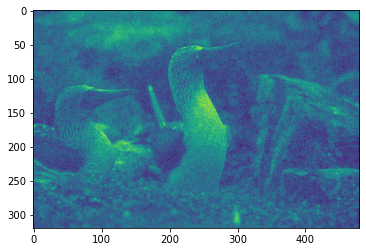

In [7]:
plt.imshow(results[0])

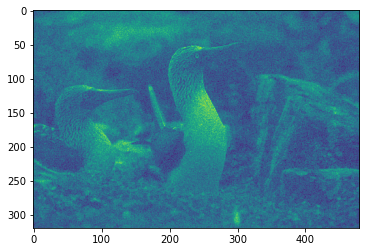

In [8]:
plt.imshow(observation[0])